In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import Binarizer

In [2]:
#Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(),inplace=True)
    df['Cabin'].fillna('N',inplace=True)
    df['Embarked'].fillna('N',inplace=True)
    df['Fare'].fillna(0,inplace=True)
    
    return df


#불필요한 변수 제거 함수
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)
    
    return df


#범주형 변수 레이블 인코딩
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin','Sex','Embarked']
    
    for i in features:
        encoder = preprocessing.LabelEncoder()
        encoder.fit(df[i])
        df[i] = encoder.transform(df[i])
        
    return df


#위의 3개 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

In [3]:
titanic_df = pd.read_csv(r'C:\Users\kis91\Desktop\python study\data\titanic\titanic_train.csv')
y_titanic_df = titanic_df['Survived']
x_titanic_df = titanic_df.drop('Survived',axis=1)
x_titanic_df = transform_features(x_titanic_df)
x_train,x_test,y_train,y_test = train_test_split(x_titanic_df,y_titanic_df,test_size=0.2,random_state=0)

In [4]:
#성별이 여자면 생존, 남자면 사망인 Classifier
def bayse_clf(df):
    pred = np.zeros((df.shape[0],1))
    for i in range(df.shape[0]):
        if df['Sex'].iloc[i]==1 : pred[i] = 0
        else : pred[i] = 1
    return pred



accuracy_score(y_test,bayse_clf(x_test))

0.7877094972067039

In [5]:
#데이터
titanic_df = pd.read_csv(r'C:\Users\kis91\Desktop\python study\data\titanic\titanic_train.csv')
y_titanic_df = titanic_df['Survived']
x_titanic_df = titanic_df.drop('Survived',axis=1)
x_titanic_df = transform_features(x_titanic_df)
x_train,x_test,y_train,y_test = train_test_split(x_titanic_df,y_titanic_df,test_size=0.2,random_state=11)



#################모델 평가(정확도,정밀도,재현율)#########################
def get_clf_eval(y_test, pred):
    #confusion 행렬
    confusion = confusion_matrix(y_test, pred)
    #정확도
    accuracy = accuracy_score(y_test, pred)
    #정밀도
    precision = precision_score(y_test, pred)
    #재현율
    recall = recall_score(y_test, pred)
    print('confusion matrix')
    print(confusion)
    print('accuracy :',np.around(accuracy,4),', precision :',np.around(precision,4),', recall :',np.around(recall,4))
    
    
    
lr_clf = LogisticRegression()
lr_clf.fit(x_train,y_train)
pred = lr_clf.predict(x_test)
get_clf_eval(y_test,pred)

confusion matrix
[[108  10]
 [ 14  47]]
accuracy : 0.8659 , precision : 0.8246 , recall : 0.7705


C:\Users\kis91\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [6]:
#정밀도/재현율 트레이드오프

pred_proba = lr_clf.predict_proba(x_test)
pred = lr_clf.predict(x_test)
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)],axis=1)
print('확률 matrix + 예측값 \n',pred_proba_result[:3],'\n')


#Binarizer을 사용한 임계값
custom_threshold = [0.4,0.45,0.5,0.55,0.6]
for i in custom_threshold:
    pred_proba_1 = pred_proba[:,1].reshape(-1,1)
    binarizer = Binarizer(threshold=i).fit(pred_proba_1)
    custom_predict = binarizer.transform(pred_proba_1)
    print('임계값 :',i)
    get_clf_eval(y_test,custom_predict)
    print('\n')


확률 matrix + 예측값 
 [[0.44935227 0.55064773 1.        ]
 [0.86335513 0.13664487 0.        ]
 [0.86429645 0.13570355 0.        ]] 

임계값 : 0.4
confusion matrix
[[97 21]
 [11 50]]
accuracy : 0.8212 , precision : 0.7042 , recall : 0.8197


임계값 : 0.45
confusion matrix
[[105  13]
 [ 13  48]]
accuracy : 0.8547 , precision : 0.7869 , recall : 0.7869


임계값 : 0.5
confusion matrix
[[108  10]
 [ 14  47]]
accuracy : 0.8659 , precision : 0.8246 , recall : 0.7705


임계값 : 0.55
confusion matrix
[[111   7]
 [ 16  45]]
accuracy : 0.8715 , precision : 0.8654 , recall : 0.7377


임계값 : 0.6
confusion matrix
[[113   5]
 [ 17  44]]
accuracy : 0.8771 , precision : 0.898 , recall : 0.7213




precisions : [0.37888199 0.375      0.37735849]
recalls : [1.         0.98360656 0.98360656]
thresholds : [0.11573101 0.11636721 0.11819211]


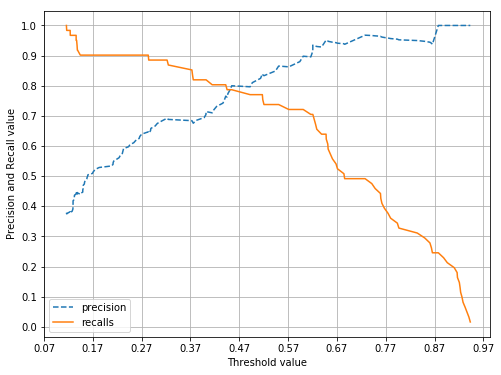

In [11]:
#정밀도/재현율 트레이드오프 그래프
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test,pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba)
    
    #그래프크기
    plt.figure(figsize=(8,6))
    #x축을 threshold값으로, y축은 정밀도, 재현율
    
    threshold_boundary = thresholds.shape[0]
    
    #plt.plot(x값,y값)
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    print('precisions :',precisions[0:3])
    print('recalls :',recalls[0:3])
    print('thresholds :',thresholds[0:3])
    
    #축 설정
    plt.xticks(np.round(np.arange(0.07,1,0.1),2))
    plt.yticks(np.round(np.arange(0,1.1,0.1),2))

    #x축 y축 label, legend, grid설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()
    
    
precision_recall_curve_plot(y_test,pred_proba[:,1])


In [8]:
# F1 Score

f1 = f1_score(y_test,pred)
print('f1 socre :',f1,'\n')




#모델 평가(정확도,정밀도,재현율+F1 Score추가)
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print('confusion matrix')
    print(confusion)
    print('accuracy :',np.around(accuracy,4),', precision :',np.around(precision,4),', recall :',np.around(recall,4),'F1 score :',np.around(f1,4))
print('함수 결과 :')
get_clf_eval(y_test,pred)





print('---------------------------------------------------------------------------------------------')
print('\ncustom threshold :',custom_threshold,'\n')
for i in custom_threshold:
    pred_proba_1 = pred_proba[:,1].reshape(-1,1)
    binarizer = Binarizer(threshold=i).fit(pred_proba_1)
    new_pred = binarizer.transform(pred_proba_1)
    print('\n-------threshold:',i,'-------')
    get_clf_eval(y_test,new_pred)
    

f1 socre : 0.7966101694915254 

함수 결과 :
confusion matrix
[[108  10]
 [ 14  47]]
accuracy : 0.8659 , precision : 0.8246 , recall : 0.7705 F1 score : 0.7966
---------------------------------------------------------------------------------------------

custom threshold : [0.4, 0.45, 0.5, 0.55, 0.6] 


-------threshold: 0.4 -------
confusion matrix
[[97 21]
 [11 50]]
accuracy : 0.8212 , precision : 0.7042 , recall : 0.8197 F1 score : 0.7576

-------threshold: 0.45 -------
confusion matrix
[[105  13]
 [ 13  48]]
accuracy : 0.8547 , precision : 0.7869 , recall : 0.7869 F1 score : 0.7869

-------threshold: 0.5 -------
confusion matrix
[[108  10]
 [ 14  47]]
accuracy : 0.8659 , precision : 0.8246 , recall : 0.7705 F1 score : 0.7966

-------threshold: 0.55 -------
confusion matrix
[[111   7]
 [ 16  45]]
accuracy : 0.8715 , precision : 0.8654 , recall : 0.7377 F1 score : 0.7965

-------threshold: 0.6 -------
confusion matrix
[[113   5]
 [ 17  44]]
accuracy : 0.8771 , precision : 0.898 , recall :

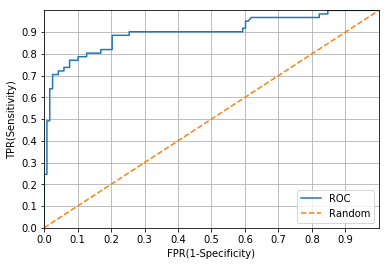

In [9]:
#ROC curve

def roc_curve_plot(y_test,proba):
    #그래프크기
    plt.figure(figsize=(6,4))
    #임계값에 따른 frps, tprs
    fprs, tprs, thresholds = roc_curve(y_test,proba)
    #ROC선
    plt.plot(fprs,tprs,label='ROC')
    #대각선
    plt.plot([0,1],[0,1],linestyle='--',label='Random')
    
    #x축 y축 스케일 설정
    plt.xlim(0,1);plt.ylim(0,1)
    plt.xticks(np.round(np.arange(0,1,0.1),2))
    plt.yticks(np.round(np.arange(0,1,0.1),2))
    #x축, y축 이름
    plt.xlabel('FPR(1-Specificity)')
    plt.ylabel('TPR(Sensitivity)')
    
    plt.legend(loc=4) #loc = 라벨 위치, 0은 best position
    plt.grid()
    plt.show()
    
roc_curve_plot(y_test,pred_proba[:,1])

In [10]:
#AUC
fprs, tprs, thresholds = roc_curve(y_test,pred_proba[:,1].reshape(-1,1))
print("AUC :",auc(fprs,tprs))
print('AUC :',roc_auc_score(y_test,pred_proba[:,1]))



AUC : 0.8986524034454015
AUC : 0.8986524034454015
